# Regression

Prediction of the output of a continuos value (like price or probability)

In [2]:
from __future__ import absolute_import, division, print_function

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.13.1


## Fecthing data

In [3]:
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

In [3]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin'] 
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


##  Cleaning data

These is the count of unknown values for each feature.

In [4]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

The simplest solution is to drop these rows.

In [5]:
dataset = dataset.dropna()

The Origin feature is categorical not numerical, so we convert it to one-hot.

In [6]:
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()
origin.tail()

393    1
394    2
395    1
396    1
397    1
Name: Origin, dtype: int64

## Preparing train and test set

In [7]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

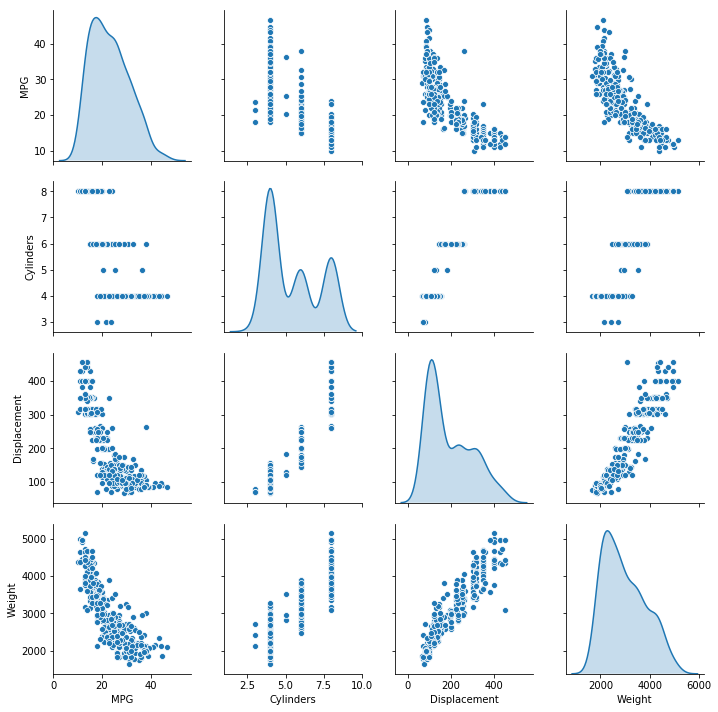

In [8]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

#### Overall statistics

In [9]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


#### Split features from labels

In [10]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

#### Standarization of the data

Features have very different ranges. It is good practice to standarize them, both training and test set. Afterwards this standarization should be applied to any data supplied to the model.

In [4]:
def std(x):
  return (x - train_stats['mean']) / train_stats['std'] # std = standard deviation

std_train_data = std(train_dataset)
std_test_data = std(test_dataset)

NameError: name 'train_dataset' is not defined

##  Building model

In [12]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [13]:
model = build_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


Using a batch of 10 examples, we get a result of expected shape and type

In [14]:
example_batch = std_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.07452573],
       [ 0.14103524],
       [ 0.5635772 ],
       [-0.01620242],
       [ 0.00851503],
       [ 0.17594233],
       [-0.00834686],
       [ 0.02530932],
       [ 0.09892672],
       [-0.05652761]], dtype=float32)

## Training the model

In [15]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  std_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

Instructions for updating:
Use tf.cast instead.

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................

In [16]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,2.419831,1.001674,2.419831,7.761292,2.100382,7.761292,995
996,2.492154,1.014695,2.492154,7.445597,2.082788,7.445597,996
997,2.375593,0.980913,2.375593,8.305652,2.197683,8.305653,997
998,2.407437,0.981926,2.407437,8.774310,2.265940,8.774309,998
999,2.419821,0.952775,2.419821,7.496795,2.084954,7.496795,999


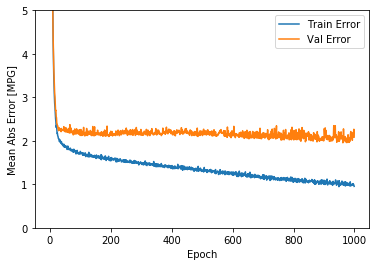

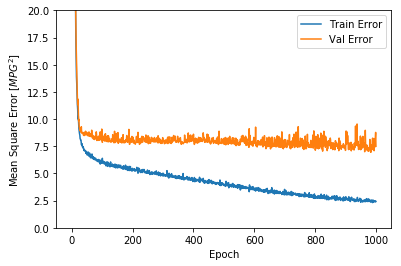

In [17]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

This model show degradation of the validation error after around 100 epochs. So we will add an EarlyStopping callback that is checked at end of every epoch and then stop when validation score doesn't improve. 


...................................................

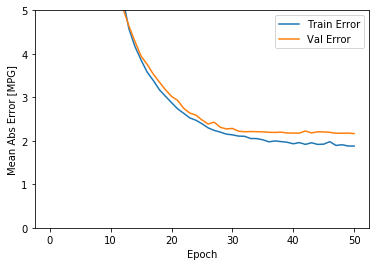

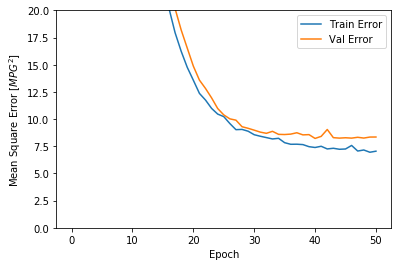

In [18]:
model = build_model()

# The patience parameter is the amount of epochs without improvement before training should stop
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(std_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

## Evaluation

In [19]:
loss, mae, mse = model.evaluate(std_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

Testing set Mean Abs Error:  1.88 MPG


#### Predictions

The model predicts reasonably well.

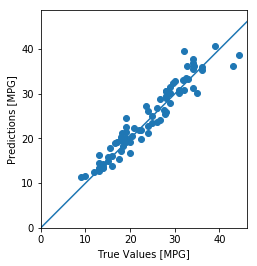

In [20]:
test_predictions = model.predict(std_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

#### Error distribution

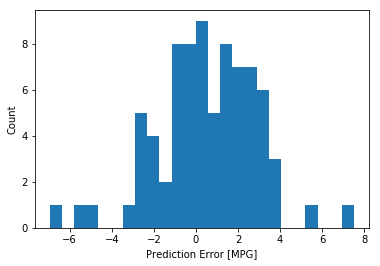

In [21]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

## Conclusion

* Mean Squared Error (MSE) is a common loss function used for regression problems (different loss functions are used for classification problems).


* Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).



* When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.


* If there is not much training data, one technique is to prefer a small network with few hidden layers to avoid overfitting.



* Early stopping is a useful technique to prevent overfitting.